# 5. Evaporation and Condensation of Multiple Chemical Species

In this notebook we wil gover how the evaporation and condestion of the components that are active in gas and dust work:
First we set up the simulation with an active comonent as described in the previous chapter:

In [1]:
from tripod import Simulation
import numpy as np
import dustpy.constants as c
import matplotlib.pyplot as plt

In [2]:
sim = Simulation()
sim.ini.grid.Nr = 500
sim.initialize()

we prepared a textfile with some example Species to get you started with an example disk, it contains most of the necesary parameters to have a disk with coposition which are:

- Species 
name of the element/molecule being tracked

- Abundance 
Abuncance relative to the total gas content

- nu_des
The attempt frequency if set to -1 we assume that the component is only present in the gas

- T_bind 
The binding energy (in Kelvin)

- mu 
Mean moleculat weight of the molecule

Further parameters that you need to set but are not part of the file as they are:

- rhos
bulk density of the componets when part of the dust

In [3]:
data = np.genfromtxt(
    'chem.txt',
    dtype=None,     # Automatically determine data types
    names=True,     # Use first non-skipped line as column names
    encoding='utf-8',  # Handle text encoding
    usecols=(0, 1, 2, 3, 4, 5),  # Specify columns to read
    comments='#'    # Skip lines starting with #
)

In [4]:
data.dtype.names  # Display column names to verify correct reading

('Species', 'Abundance', 'nu_des', 'T_bind', 'mu', 'p_stick')

the additional Species can then be added in the folowing way:

In [ ]:
# Initialize residual gas surface density to total gas surface density
Sig_residual = sim.gas.Sigma.copy()
for element in data:
    if element["nu_des"] <= 0:
        sim.addcomponent_c(
        element['Species'],
        sim.gas.Sigma*element['Abundance'],
        element['mu']*c.m_p,
        dust_active=False,
        gas_active=True)
        Sig_residual -= sim.gas.Sigma*element['Abundance']
        continue  # Skip elements with non-positive desorption frequency

    factor = np.where(sim.dust.Sigma[:,0] > sim.dust.SigmaFloor[:,0], 1.0, 0.0)
    sim.addcomponent_c(
        element['Species'],
        sim.gas.Sigma*element['Abundance']*factor,
        element['mu']*c.m_p,
        dust_active=True,
        gas_active=True,
        rhos=1.,
        dust_value = sim.dust.SigmaFloor.copy()
    )
    sim.components.__dict__[element[0]].gas.pars.nu = element['nu_des']
    sim.components.__dict__[element[0]].gas.pars.Tsub = element['T_bind']
    Sig_residual -= sim.gas.Sigma*element['Abundance']

# Add the background silicate dust component
sim.addcomponent_c("silicates",
    sim.gas.SigmaFloor,
    1.,
    dust_active=True,
    gas_active=False,
    rhos=sim.dust.rhos[0,0],
    dust_value = sim.dust.Sigma.copy())

# Note that we have to subtract the assigned gas from the Default component and reassign it H2 like properties
sim.components.Default.gas.Sigma = Sig_residual # Assign remaining gas to Default component
sim.components.Default.gas.pars.mu = 2*c.m_p # Ensure Default component is H2
sim.update()

In [6]:
sim.components

Group (components)
------------------
    Ar           : Group (Ar (dust_tracer=False, gas_active=True, gas_tracer=False))
    C2H6         : Group (C2H6 (dust_tracer=False, gas_active=True, gas_tracer=False))
    CH3OH        : Group (CH3OH (dust_tracer=False, gas_active=True, gas_tracer=False))
    CH4          : Group (CH4 (dust_tracer=False, gas_active=True, gas_tracer=False))
    CO           : Group (CO (dust_tracer=False, gas_active=True, gas_tracer=False))
    CO2          : Group (CO2 (dust_tracer=False, gas_active=True, gas_tracer=False))
    Default      : Group (Default gas componentDefault (dust_tracer=False, gas_active=True, gas_tracer=False))
    FeS          : Group (FeS (dust_tracer=False, gas_active=True, gas_tracer=False))
    H2O          : Group (H2O (dust_tracer=False, gas_active=True, gas_tracer=False))
    H2S          : Group (H2S (dust_tracer=False, gas_active=True, gas_tracer=False))
    He           : Group (He (dust_tracer=False, gas_active=True, gas_tracer

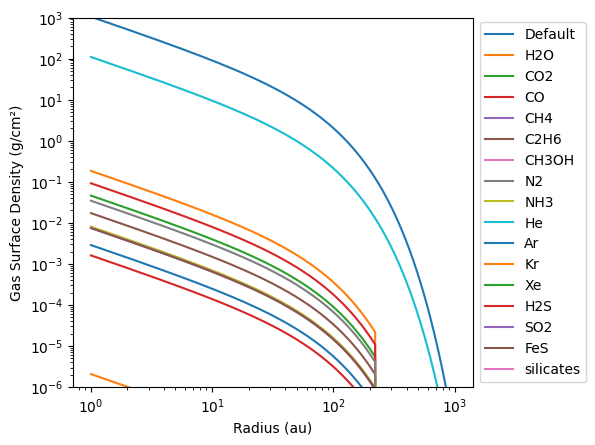

In [7]:
plt.figure()

for name, comp in sim.components.__dict__.items():
    if(name.startswith("_")):
            continue
    plt.loglog(sim.grid.r/c.au, comp.gas.Sigma, label=name)

plt.xlabel('Radius (au)')
plt.ylabel('Gas Surface Density (g/cm²)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.ylim(1e-6, 1e3)
plt.show()

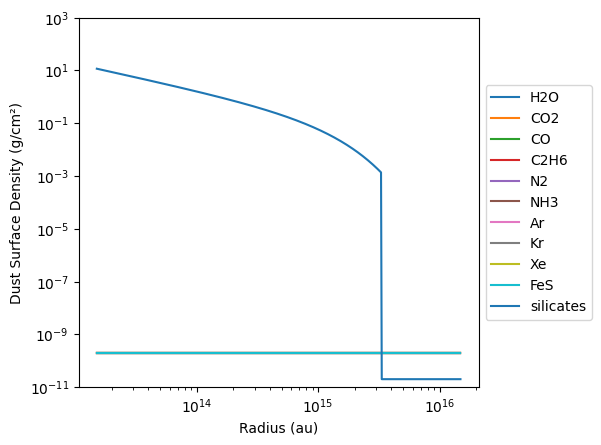

In [8]:
plt.figure()

for name, comp in sim.components.__dict__.items():
    if(name.startswith("_")):
            continue
    if comp.dust._active:
        plt.loglog(sim.grid.r, comp.dust.Sigma.sum(-1), label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.ylim(1e-11, 1e3)
plt.xlabel('Radius (au)')
plt.ylabel('Dust Surface Density (g/cm²)')
plt.show()

In [9]:
sim.t.snapshots = [1e5*c.year]
sim.writer.overwrite = True
sim.run()


TriPoD v0.0.1

Writing file data/data0000.hdf5
Writing dump file data/frame.dmp
Execution time: 0:06:35


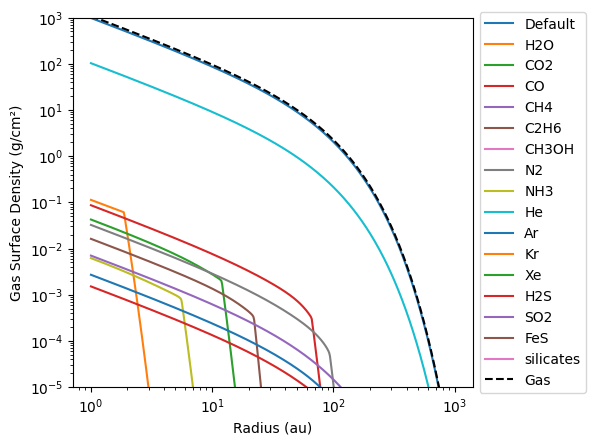

In [21]:
plt.figure()

for name, comp in sim.components.__dict__.items():
    if(name.startswith("_")):
            continue
    plt.loglog(sim.grid.r/c.au, comp.gas.Sigma, label=name)

plt.loglog(sim.grid.r/c.au, sim.gas.Sigma, "k--", label="Gas")
plt.xlabel('Radius (au)')
plt.ylabel('Gas Surface Density (g/cm²)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.ylim(1e-5, 1e3)
plt.show()

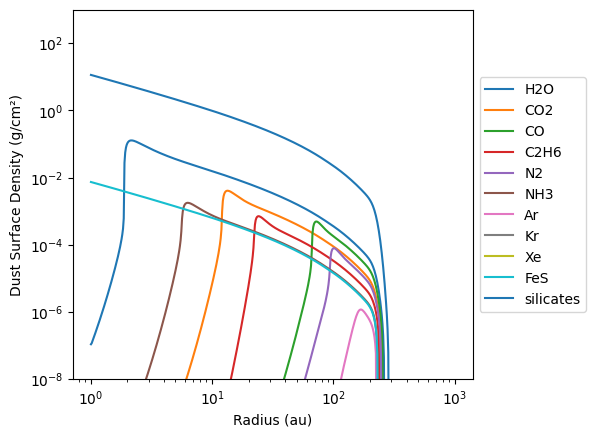

In [24]:
plt.figure()

for name, comp in sim.components.__dict__.items():
    if(name.startswith("_")):
            continue
    if comp.dust._active:
        plt.loglog(sim.grid.r/c.au, comp.dust.Sigma.sum(-1), label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.ylim(1e-8, 1e3)
plt.xlabel('Radius (au)')
plt.ylabel('Dust Surface Density (g/cm²)')
plt.show()

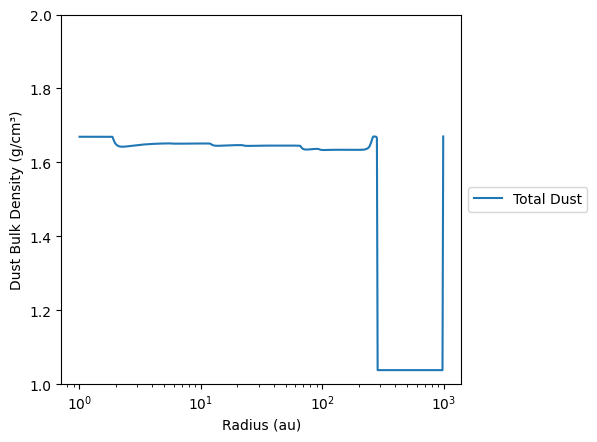

In [26]:
plt.figure()
plt.plot(sim.grid.r/c.au, sim.dust.rhos[:,0], label="Total Dust")
plt.xscale('log')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.75)
plt.xlabel('Radius (au)')
plt.ylabel('Dust Bulk Density (g/cm³)')
plt.ylim(1,2)
plt.show()